In [66]:
import os
import random
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Activation, Add, AveragePooling2D, Dense,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image


In [67]:
# Specify the directory
root_directory = 'C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset'

# List of desired labels in the specified order
labels_list = ['dew', 'fogsmog', 'glaze', 'rime', 'sandstorm']

In [68]:
# Initialize empty lists to store file paths and labels for the entire dataset
X, y = [], []

# Gather files and labels for the entire dataset
for label_idx, label in enumerate(labels_list):
     # Construct the directory path for the current label
    label_directory = os.path.join(root_directory, label)
     # Iterate through files in the label directory
    for file_name in os.listdir(label_directory):
         # Construct the full file path
        file_path = os.path.join(label_directory, file_name)
         # Append file path and corresponding label index to lists
        X.append(file_path)
        y.append(label_idx)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

# Convert y_train, y_val and y_test to categorical 
num_classes = len(labels_list)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Create folders for training and testing sets
for dataset_type, X_data, y_data in [('train', X_train, y_train),  ('val', X_val, y_val),('test', X_test, y_test)]:
    # Construct the directory path for the current dataset type
    dataset_directory = os.path.join(root_directory, dataset_type)
    os.makedirs(dataset_directory, exist_ok=True)
 # Iterate through data in the current dataset
    for file_path, label in zip(X_data, y_data):
        # Get the label folder name based on one-hot encoded label
        label_folder = labels_list[label.argmax()]
         # Construct the destination folder path
        destination_folder = os.path.join(dataset_directory, label_folder)
        os.makedirs(destination_folder, exist_ok=True)
        
         # Extract the file name from the file path
        file_name = os.path.basename(file_path)
        
        # Construct the destination file path
        destination_path = os.path.join(destination_folder, file_name)
         # Copy the file from the source to the destination
        shutil.copy(file_path, destination_path)


In [69]:
def print_dataset_info(dataset_name, path):
    print(f"{dataset_name} DATASET")
    print("==================================================================")
    # Initialize a counter for total files in the dataset
    total_files = 0
    # Iterate through the directory structure using os.walk
    for root, dirs, files in os.walk(path):
         # Check if there are files in the current directory
        if files != []:
              # Print the current directory and the number of files in it
            print(f"{root} ---> {len(files)}")
             # Update the total file count
            total_files += len(files)
    # Print a separator line and the total file count for the entire dataset
    print("==================================================================")
    print(f"TOTAL = {total_files}\n\n")

# Printing information for each dataset
print_dataset_info("TRAIN", 'C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset\\train')
print_dataset_info("VAL", 'C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset\\val')
print_dataset_info("TEST", 'C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset\\test')


TRAIN DATASET
C:\Users\Noura\Downloads\72917-Group5\dataset\train\dew ---> 419
C:\Users\Noura\Downloads\72917-Group5\dataset\train\fogsmog ---> 511
C:\Users\Noura\Downloads\72917-Group5\dataset\train\glaze ---> 383
C:\Users\Noura\Downloads\72917-Group5\dataset\train\rime ---> 696
C:\Users\Noura\Downloads\72917-Group5\dataset\train\sandstorm ---> 415
TOTAL = 2424


VAL DATASET
C:\Users\Noura\Downloads\72917-Group5\dataset\val\dew ---> 105
C:\Users\Noura\Downloads\72917-Group5\dataset\val\fogsmog ---> 127
C:\Users\Noura\Downloads\72917-Group5\dataset\val\glaze ---> 96
C:\Users\Noura\Downloads\72917-Group5\dataset\val\rime ---> 174
C:\Users\Noura\Downloads\72917-Group5\dataset\val\sandstorm ---> 104
TOTAL = 606


TEST DATASET
C:\Users\Noura\Downloads\72917-Group5\dataset\test\dew ---> 174
C:\Users\Noura\Downloads\72917-Group5\dataset\test\fogsmog ---> 213
C:\Users\Noura\Downloads\72917-Group5\dataset\test\glaze ---> 160
C:\Users\Noura\Downloads\72917-Group5\dataset\test\rime ---> 290
C:\U

In [70]:
# Define data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
   'C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset\\train',
    target_size=(224, 224), # Resize images to (224, 224) during loading
    batch_size=32, # Number of samples per batch
    class_mode='categorical', # Categorical labels for multi-class classification
    shuffle=True  # Shuffle the data for better training
)
# Validation Data Generator
val_generator = val_datagen.flow_from_directory(
   'C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset\\val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle the validation data
)
# Test Data Generator
test_generator = test_datagen.flow_from_directory(
   'C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset\\test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle the test data
)


Found 2424 images belonging to 5 classes.
Found 606 images belonging to 5 classes.
Found 1010 images belonging to 5 classes.


In [71]:
# Check GPU availability
# Get a list of available physical devices (e.g., GPUs)
physical_devices = tf.config.list_physical_devices('GPU')
# Check if there are any GPUs available
if physical_devices:
    # Enable dynamic GPU memory growth to allocate memory as needed 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [72]:
def identity_block(x, filters):
    # Identity block with three convolutional layers
    x_shortcut = x

    x = Conv2D(filters[0], (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = Conv2D(filters[1], (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = Conv2D(filters[2], (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def conv_block(x, filters, stride):
    # Convolutional block with shortcut connection
    x_shortcut = x

    x = Conv2D(filters[0], (1, 1), strides=(stride, stride), padding='valid')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = Conv2D(filters[1], (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = Conv2D(filters[2], (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x_shortcut = Conv2D(filters[2], (1, 1), strides=(stride, stride), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def build_resnet15(input_shape=(224, 224, 3), num_classes=5):
    # Building ResNet15 model
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(32, (7, 7), strides=(2, 2), padding='valid')(input_tensor)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    # Convolutional blocks
    x = conv_block(x, [32, 32, 64], stride=1)
    x = identity_block(x, [64, 64, 64])

    x = conv_block(x, [64, 64, 128], stride=2)
    x = identity_block(x, [128, 128, 128])

    x = conv_block(x, [128, 128, 256], stride=2)
    x = identity_block(x, [256, 256, 256])

    x = conv_block(x, [256, 256, 512], stride=2)
    x = identity_block(x, [512, 512, 512])

    x = AveragePooling2D((4, 4), padding='valid')(x)
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Instantiate the ResNet15 model
model = build_resnet15()

# Define recall and precision metrics
recall_metric = Recall()
precision_metric = Precision()

# Compile the model
model.compile( optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy', recall_metric, precision_metric])

# Display the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 109, 109, 32)         4736      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_29 (Ba  (None, 109, 109, 32)         128       ['conv2d_29[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_25 (Activation)  (None, 109, 109, 32)         0         ['batch_normalization_29

                                                                                                  
 conv2d_38 (Conv2D)          (None, 27, 27, 64)           36928     ['activation_32[0][0]']       
                                                                                                  
 batch_normalization_38 (Ba  (None, 27, 27, 64)           256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_33 (Activation)  (None, 27, 27, 64)           0         ['batch_normalization_38[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 27, 27, 128)          8320      ['activation_33[0][0]']       
          

                                                                                                  
 activation_40 (Activation)  (None, 14, 14, 256)          0         ['add_12[0][0]']              
                                                                                                  
 conv2d_48 (Conv2D)          (None, 14, 14, 256)          65792     ['activation_40[0][0]']       
                                                                                                  
 batch_normalization_48 (Ba  (None, 14, 14, 256)          1024      ['conv2d_48[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_41 (Activation)  (None, 14, 14, 256)          0         ['batch_normalization_48[0][0]
                                                                    ']                            
          

                                                                                                  
 add_15 (Add)                (None, 7, 7, 512)            0         ['batch_normalization_57[0][0]
                                                                    ',                            
                                                                     'activation_46[0][0]']       
                                                                                                  
 activation_49 (Activation)  (None, 7, 7, 512)            0         ['add_15[0][0]']              
                                                                                                  
 average_pooling2d_1 (Avera  (None, 1, 1, 512)            0         ['activation_49[0][0]']       
 gePooling2D)                                                                                     
                                                                                                  
 flatten_1

In [73]:
# Define a learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Store learning rates and accuracy
learning_rates = []   # List to store learning rates during training
accuracies = []  # List to store accuracy values during training

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)


# Custom callback to log learning rates and accuracy
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        learning_rates.append(lr)

    def on_epoch_end(self, epoch, logs=None):
        accuracies.append(logs.get('accuracy'))

In [74]:
# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/50
76/76 [==============================] - 96s 1s/step - loss: 1.0705 - accuracy: 0.5615 - recall_1: 0.3998 - precision_1: 0.6916 - val_loss: 1.8322 - val_accuracy: 0.2096 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0100
Epoch 2/50
76/76 [==============================] - 84s 1s/step - loss: 0.7333 - accuracy: 0.7092 - recall_1: 0.6415 - precision_1: 0.7608 - val_loss: 2.5815 - val_accuracy: 0.2822 - val_recall_1: 0.2657 - val_precision_1: 0.2875 - lr: 0.0100
Epoch 3/50
76/76 [==============================] - 84s 1s/step - loss: 0.6557 - accuracy: 0.7463 - recall_1: 0.6968 - precision_1: 0.7794 - val_loss: 1.5751 - val_accuracy: 0.4158 - val_recall_1: 0.3597 - val_precision_1: 0.4570 - lr: 0.0100
Epoch 4/50
76/76 [==============================] - 84s 1s/step - loss: 0.5927 - accuracy: 0.7616 - recall_1: 0.7219 - precision_1: 0.7926 - val_loss: 0.9249 - val_accuracy: 0.6700 - val_recall_1: 0.4521 - val_precision_1: 0.7919 - lr: 0.0100
Epoch 5/50
76/76 [==

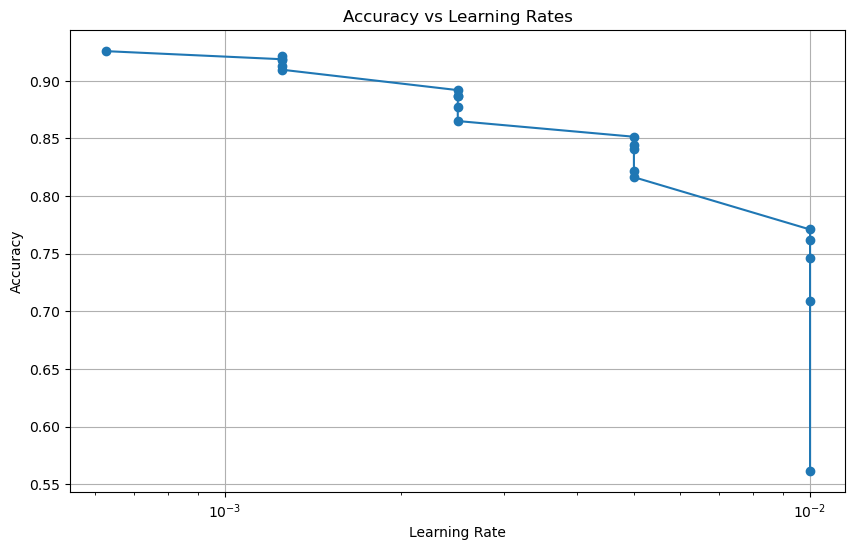

In [75]:
# Fit the model with training and validation data
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping, lr_scheduler, LearningRateLogger()])

# Plotting accuracy against learning rates
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracies, marker='o')
plt.title('Accuracy vs Learning Rates')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')  # Set x-axis to logarithmic scale for better visualization if needed
plt.grid(True)
plt.show()

In [76]:
# Evaluate the model on the test generator
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test_generator)
# Print evaluation metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')  

32/32 [==============================] - 9s 262ms/step - loss: 0.4405 - accuracy: 0.8475 - recall_1: 0.8327 - precision_1: 0.8608
Test Loss: 0.4405
Test Accuracy: 0.8475
Test Precision: 0.8608
Test Recall: 0.8327


32/32 [==============================] - 8s 250ms/step


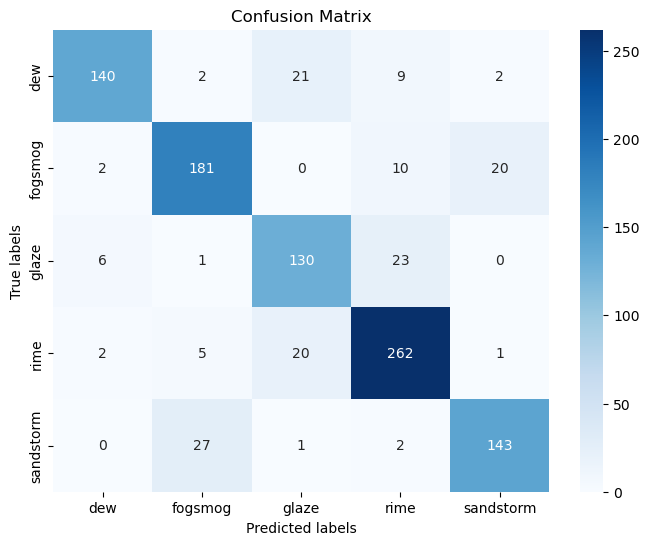

In [83]:
# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 57ms/step


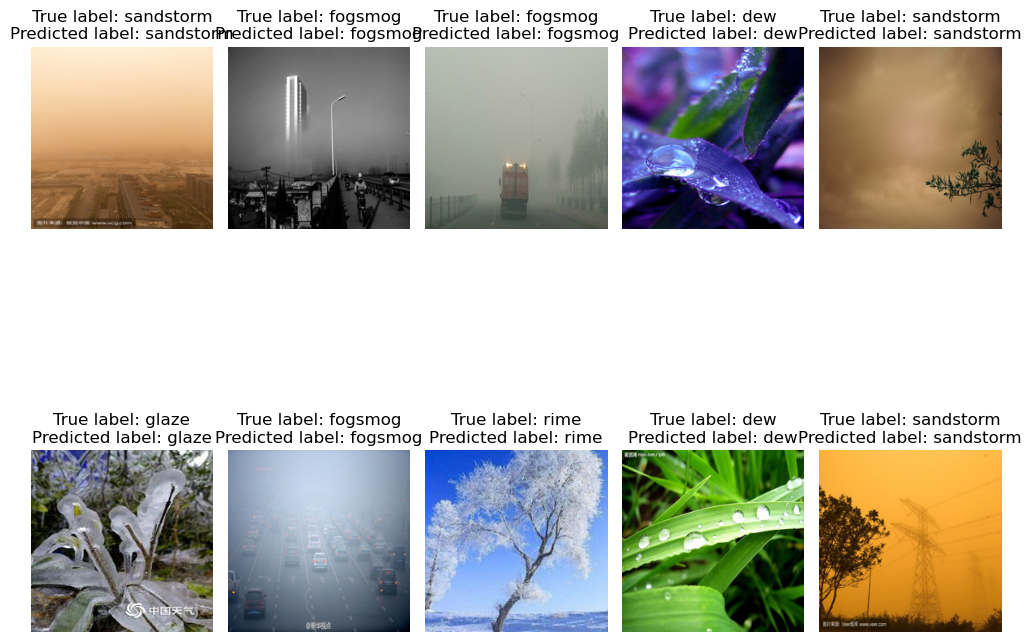

In [86]:
# Display a couple of test images with true and predicted labels
num_images_to_display = 10  # Specify the number of images to display
num_cols = 5  # Number of columns in the grid
num_rows = (num_images_to_display + num_cols - 1) // num_cols  # Calculate number of rows needed
indices = np.random.choice(len(test_generator.filenames), num_images_to_display)

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))  # Adjust figsize as needed

for i, idx in enumerate(indices):
    row = i // num_cols
    col = i % num_cols

    image_path = os.path.join('C:\\Users\\Noura\\Downloads\\72917-Group5\\dataset\\test', test_generator.filenames[idx])
    
    # Load and resize the image
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0  # Normalize pixel values
    
    # Reshape and predict
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    true_class = test_generator.classes[idx]

    # Display image and labels in subplots
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"True label: {labels_list[true_class]}\nPredicted label: {labels_list[predicted_class]}")

# Hide empty subplots if num_images_to_display is less than num_cols * num_rows
for i in range(num_images_to_display, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()
